# Lab3:异常检测

## 数据集介绍
数据集简介：美国领先的零售商店之一沃尔玛希望准确预测销售额以及消费者需求，某些事件和假期对每周的销售的影响。现在有沃尔玛 45 家门店的销售数据以及一些颇具参考意义的属性，同样其中也不乏出现异常销量的异常点。

该数据集包含以下列：
['Store','Date','IsHoliday', 'Dept', 'Weekly_Sales', 'Temperature', 'Fuel_Price', 'Unemployment']

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

In [2]:
walmart = pd.read_csv("data\walmart_cleaned.csv")


df = walmart.loc[walmart['Store'] == 10]

df['Date'] = pd.to_datetime(df['Date'])
ls_mo = []
for i in df['Date']:
    ls_mo.append(i.month)
df['month'] = ls_mo

c:\Users\13521\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\13521\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


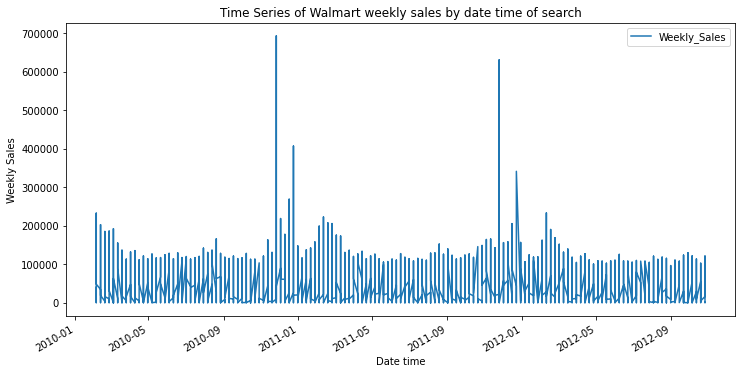

In [3]:
df.plot(x='Date', y='Weekly_Sales', figsize=(12,6))
plt.xlabel('Date time')
plt.ylabel('Weekly Sales')
plt.title('Time Series of Walmart weekly sales by date time of search');

In [4]:
outliers_fraction = 0.01
df = df.sort_values('Date')
df['date_time_int'] = df.Date.astype(np.int64)

ls_an = []
#周销量大于350000为异常点，进行标注，为后面使用AutoEncoder以及SVM服务
for i in df['Weekly_Sales']:
    if i > 350000:
        ls_an.append(-1)
    else:
        ls_an.append(1)
df['anomaly'] = ls_an

c:\Users\13521\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  This is separate from the ipykernel package so we can avoid doing imports until


## OneClassSVM:

sklearn提供了一些机器学习方法，可用于奇异（Novelty）点或者异常（Outlier）点检测，包括OneClassSVM，Isolation Forest，Local Outlier Factor（LOF）等，其中OneCLassSVM可以用于Novelty Dection，而后两者可用于Outlier Detection。
　　严格来说，OneCLassSVM不是一种outlier detection，而是一种novelty detection方法：它的训练集不应该掺杂异常点，因为模型可能会去匹配这些异常点。但在数据维度很高，或者对相关数据分布没有任何假设的情况下，OneClassSVM也可以作为一种很好的outlier detection方法。
在one-class classification中，仅仅只有一类的信息是可以用于训练，其他类别的（总称outlier）信息是缺失的，也就是区分两个类别的边界线是通过仅有的一类数据的信息学习得到的。
   SVM需要使用正常数据来训练。
算法步骤：
假设产生的超球体参数为中心 o 和对应的超球体半径 r >0，超球体体积V(r) 被最小化，中心 o 是支持行了的线性组合；跟传统SVM方法相似，可以要求所有训练数据点xi到中心的距离严格小于r。但是同时构造一个惩罚系数为 C 的松弛变量 ζi ,优化问题如下所示：

$\begin{array}{c}
\underbrace{\min }_{r, o} V(r)+C \sum_{i=1}^{m} \zeta_{i} \\
\left\|x_{i}-o\right\|_{2} \leq r+\xi_{i}, i=1,2,3 \ldots m \\
\xi_{i} \geq 0, i=1,2, \ldots m
\end{array}$

采用拉格朗日对偶求解之后，可以判断新的数据点 z 是否在内，如果 z 到中心的距离小于或者等于半径 r ，则不是异常点，如果在超球体以外，则是异常点。

应用场景：
利用One-Class SVM，它有能力捕获数据集的形状,因此对于强非高斯数据有更加优秀的效果，例如两个截然分开的数据集。严格来说，一分类的SVM并不是一个异常点监测算法，而是一个奇异点检测算法：它的训练集不能包含异常样本，否则的话，可能在训练时影响边界的选取。但是，对于高维空间中的样本数据集，如果它们做不出有关分布特点的假设，One-class SVM将是一大利器。


svm_accuracy:0.9917595734367426


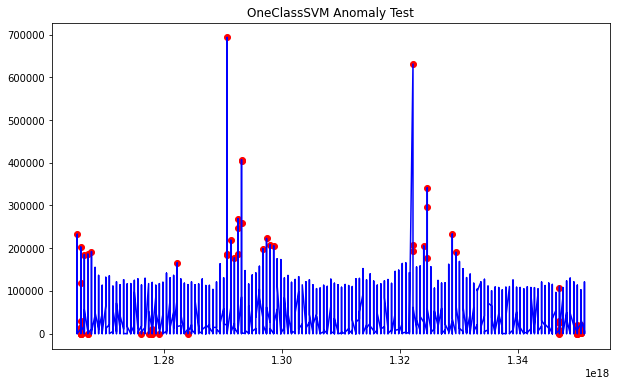

In [5]:
data = df[['IsHoliday', 'Dept', 'Weekly_Sales', 'Temperature', 'Fuel_Price', 'Unemployment']]
data = data.loc[data['Weekly_Sales']<=350000]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train oneclassSVM 
svm = OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.01)
svm.fit(data)
data = df[['IsHoliday', 'Dept', 'Weekly_Sales', 'Temperature', 'Fuel_Price', 'Unemployment']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
df['anomaly_svm'] = svm.predict(data)
svm_acc = accuracy_score(df['anomaly_svm'], ls_an)
print(f"svm_accuracy:{svm_acc}")

fig, ax = plt.subplots(figsize=(10,6))
a = df.loc[df['anomaly_svm'] == -1, ['date_time_int', 'Weekly_Sales']] #anomaly

ax.plot(df['date_time_int'], df['Weekly_Sales'], color='blue',label = 'Normal')
ax.scatter(a['date_time_int'],a['Weekly_Sales'], color='red',label = 'Anomaly')
plt.title('OneClassSVM Anomaly Test')
plt.show();

## 孤立森林：
孤立森林与随机森林非常相似，它是基于给定数据集的决策树集成而建立的。然而，也有一些区别。孤立森林将异常识别为树上平均路径较短的观测结果。每个孤立树都应用了一个过程:

1.随机选择两个特征。

2.通过在所选特征的最大值和最小值之间随机选择一个值来分割数据点。

观察值的划分递归地重复，直到所有的观察值被孤立。
孤立树的建立是通过对样本的递归分割 实现的，直到孤立树达到最大高度或者独立样本，树的最大高度l与样本数量的关系是
l=ceiling(),其近似等于树的平均高度，我们只关心路径长度较小的那些点，他们更有可能是疑似异常点。

应用场景：
孤立森林算法内存要求低，处理速度快，时间复杂度是线性的，可以处理高维数据和大数据，可以进行在线预测；即能发现群异常数据，也能发现散点异常数据，也能处理训练数据中不包含异常数据的情况。

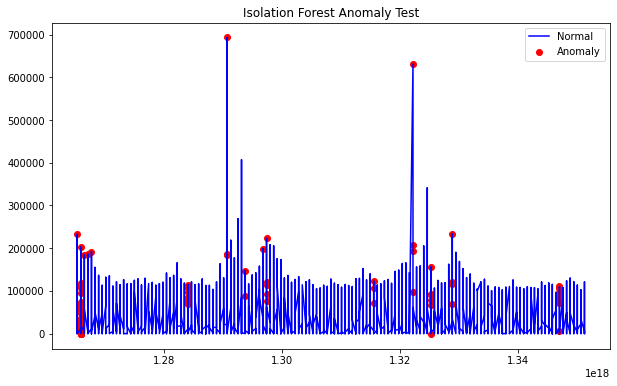

In [6]:
data = df[['IsHoliday', 'Dept', 'Weekly_Sales', 'Temperature', 'Fuel_Price', 'Unemployment']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
#train isolation forest
isoforest =  IsolationForest(n_estimators=100, max_samples='auto', 
                           contamination=outliers_fraction, max_features=6)

df['anomaly_iso'] = isoforest.fit_predict(data)

# visualization
fig, ax = plt.subplots(figsize=(10,6))

a = df.loc[df['anomaly_iso'] == -1, ['date_time_int', 'Weekly_Sales']] #anomaly

ax.plot(df['date_time_int'], df['Weekly_Sales'], color='blue', label = 'Normal')
ax.scatter(a['date_time_int'],a['Weekly_Sales'], color='red', label = 'Anomaly')
plt.legend()
plt.title('Isolation Forest Anomaly Test')
plt.show();

## AutoEncoder:
   Auto-Encoder，中文称作自编码器，是一种无监督式学习模型。它基于反向传播算法与最优化方法（如梯度下降法），利用输入数据  本身作为监督，来指导神经网络尝试学习一个映射关系，从而得到一个重构输出  。在时间序列异常检测场景下，异常对于正常来说是少数，所以我们认为，如果使用自编码器重构出来的输出  跟原始输入的差异超出一定阈值（threshold）的话，原始时间序列即存在了异常。
   通过算法模型包含两个主要的部分：Encoder（编码器）和Decoder（解码器）。
   编码器的作用是把高维输入  编码成低维的隐变量  从而强迫神经网络学习最有信息量的特征；解码器的作用是把隐藏层的隐变量  还原到初始维度，最好的状态就是解码器的输出能够完美地或者近似恢复出原来的输入。
   同样的，AutoEncoder需要使用正常数据集进行训练。
   
应用场景：
Dimensionality reduction
Anomaly detection
Image denoising
Image compression
Image generation


In [7]:
data['anomaly'] = ls_an
features = data.drop('anomaly',axis=1)
target = data['anomaly']

x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, stratify=target
)

# use case is novelty detection so use only the normal data
# for training
train_index = y_train[y_train == 1].index
train_data = x_train.loc[train_index]

# min max scale the input data
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(train_data.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

数据预处理为适合AutoEncoder处理的格式

(8249, 6)
Epoch 1/50
33/33 [==============================] - 2s 15ms/step - loss: 0.0718 - mse: 0.1271 - val_loss: 0.0705 - val_mse: 0.1245
Epoch 2/50
33/33 [==============================] - 0s 4ms/step - loss: 0.0704 - mse: 0.1244 - val_loss: 0.0691 - val_mse: 0.1220
Epoch 3/50
33/33 [==============================] - 0s 4ms/step - loss: 0.0690 - mse: 0.1220 - val_loss: 0.0678 - val_mse: 0.1196
Epoch 4/50
33/33 [==============================] - 0s 5ms/step - loss: 0.0676 - mse: 0.1196 - val_loss: 0.0664 - val_mse: 0.1173
Epoch 5/50
33/33 [==============================] - 0s 5ms/step - loss: 0.0663 - mse: 0.1174 - val_loss: 0.0652 - val_mse: 0.1151
Epoch 6/50
33/33 [==============================] - 0s 5ms/step - loss: 0.0651 - mse: 0.1153 - val_loss: 0.0640 - val_mse: 0.1131
Epoch 7/50
33/33 [==============================] - 0s 4ms/step - loss: 0.0639 - mse: 0.1132 - val_loss: 0.0628 - val_mse: 0.1111
Epoch 8/50
33/33 [==============================] - 0s 5ms/step - loss: 0.0627 

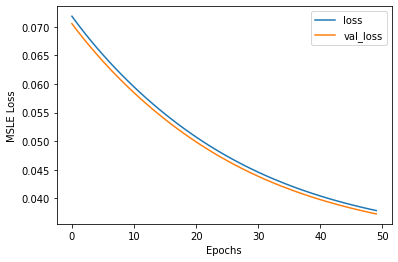

In [8]:
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=8):
    super().__init__()
    self.encoder = Sequential([
      
      Dense(4, activation='relu'),
      Dropout(0.1),
      Dense(2, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(2, activation='relu'),
      Dropout(0.1),
      Dense(4, activation='relu'),
      Dropout(0.1),
      
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
print(x_train_scaled.shape)
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='msle', metrics=['mse'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=50,
    batch_size=256,
    validation_data=(x_test_scaled, x_test_scaled)
)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

AutoEncoder编码解码部分，我们原数据维度为6，按照X->4->2->4->X'的加解码方式重构数据。训练完毕后输出loss与value loss曲线。

In [9]:
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 0 = anomaly, 1 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: -1.0 if x == True else 1.0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")

predictions = get_predictions(model, x_test_scaled, threshold)
#print(predictions.value_counts())
acc_score = accuracy_score(predictions, y_test)
print(f"accuracy: {acc_score}")

258/258 [==============================] - 1s 2ms/step
Threshold: 0.0530241899086475
65/65 [==============================] - 0s 2ms/step
accuracy: 0.8691226369365003


定义阈值并进行预测，阈值定义采用平均值+标准差。

323/323 [==============================] - 1s 2ms/step


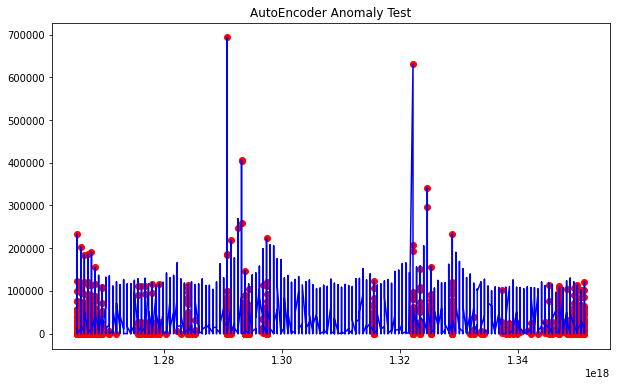

In [10]:
data = df[['IsHoliday', 'Dept', 'Weekly_Sales', 'Temperature', 'Fuel_Price', 'Unemployment']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)


data_scaled = min_max_scaler.transform(data.copy())
pred = get_predictions(model, data_scaled, threshold)
list_pred = []
for i in pred:
    list_pred.append(i)
df['anomaly_ae'] = list_pred
#print(df['anomaly_ae'].value_counts())
fig, ax = plt.subplots(figsize=(10,6))
a = df.loc[df['anomaly_ae'] == -1, ['date_time_int', 'Weekly_Sales']] #anomaly

ax.plot(df['date_time_int'], df['Weekly_Sales'], color='blue',label = 'Normal')
ax.scatter(a['date_time_int'],a['Weekly_Sales'], color='red',label = 'Anomaly')
plt.title('AutoEncoder Anomaly Test')
plt.show();

使用训练好的模型预测数据集中的异常点。

## 参考网址：
数据集：https://www.kaggle.com/c/expedia-personalized-sort/data
孤立森林：https://blog.csdn.net/weixin_43999733/article/details/104355598
		  https://cloud.tencent.com/developer/article/1814601
oneclasssvm：https://blog.csdn.net/qq_19446965/article/details/118742147
			 https://cloud.tencent.com/developer/article/1010835 
AutoEncoder：https://www.tensorflow.org/tutorials/generative/autoencoder
